# M5 Forecasting - Accuracy
**Estimate the unit sales of Walmart retail goods**

**Задача** - провести анализ и следать предсказание продаж товаров на 28 дней вперед.

**Данные**

Мы работаем с 42840 иерархическими временными рядами. Данные получены в трех штатах США (Калифорния, Техас, Висконсин). Иерархические - значит что данные могут быть сгруппированы на различных уровнях: item, department, product category и штат. Информация о продажах собрана с июня 2011 по июнь 2016. В дополнение к числу продаж, нам также предоставлены соответствующие даты с ценами, промоакциями и праздниками. Также нас предупредили, что **большая часть временных рядов содержит нули**.

Данные содержат **3049** продуктов из 3 категорий и 7 отделов, проданных в 10 магазинах в трех штатах. Мы можем создать 1 временной ряд для всех продаж, 3 временных ряда по штатам и т.д. Самая большая категория - это продажи всех 3049 товаров в 10 магазинах что дает 30 390 временных рядов.

Данные содержатся в файлах:
- **calendar.csv** - содержит информацию о датах, на которые продавались товары
- **sales_train_validation.csv** - содержит исторические данные о продажах каждого продукта по магазинам [d_1 - d_1913]
- sample_submission.csv - формат файла для сабмишена
- **sell_prices.csv** - содержит информацию о стоимости продуктов проданных в каждом магазине в определенную дату
- sales_train_evaluation.csv - будет доступен за месяц до завершения соревнования. Содержит информацию о продажах [d_1 - d_1941]

**Метрика** - Weighted Root Mean Squared Scaled Error (RMSSE). Она вычисляется для каждого временного ряда и затем усредняется по всем рядам с весами, которые определяются пропорционально продажам конкретного товара в долларах, чтобы более значимыми были товары с высокими продажами. Веса определяются по последним 28 дням тренировочных данных (которые видимо предоставят за месяц до дедлайна)

## EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# функция оптимизирующая место занимаемое набором данных
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загружаем данные

In [3]:
# sales_df = pd.read_csv("../data/input/sales_train_validation.csv", index_col='id')
# prices_df = pd.read_csv("../data/input/sell_prices.csv", index_col='store_id')
# calendar_df = pd.read_csv("../data/input/calendar.csv", index_col='date')
# sample_submit = pd.read_csv("../data/input/sample_submission.csv", index_col='id')
sales_df = pd.read_csv("../data/input/sales_train_validation.csv")
prices_df = pd.read_csv("../data/input/sell_prices.csv")
calendar_df = pd.read_csv("../data/input/calendar.csv")
sample_submit = pd.read_csv("../data/input/sample_submission.csv")

In [4]:
sales_df = reduce_mem_usage(sales_df, True)
prices_df = reduce_mem_usage(prices_df, True)
calendar_df = reduce_mem_usage(calendar_df, True)
sample_submit = reduce_mem_usage(sample_submit, True)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%
Memory usage of dataframe is 13.49 MB
Memory usage after optimization is: 4.83 MB
Decreased by 64.2%


#### Продажи

Данные по количеству покупок каждого товара за каждый день за исследуемый период

In [5]:
def print_df_info(df):
    print(f"Shape of train data: {df.shape}")
    print(df.info())

In [6]:
print_df_info(sales_df)
sales_df.head()

Shape of train data: (30490, 1919)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.4 MB
None


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


- id - обозначает тоже самое, что в submission с той лишь разницей, что тут данные только для открытой части соревнования
- item_id - идентификатор товара (FOODS_3_629 - 629 товар 3-й подкатегории категории Еда)
- dept_id - идентификатор подкатегории
- cat_id - идентификатор категории
- store_id - идентификатор магазина
- state_id - идентификатор штата
- d_1..d_1913 - сведения о количестве товаров купленных по каждому товару за каждый день

#### Цены товаров

In [7]:
print_df_info(prices_df)
prices_df.head()

Shape of train data: (6841121, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB
None


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


- store_id - идентификатор магазина (включает наименование штата)
- item_id - идентификатор продукта (включает категорию и подкатегорию товара)
- wm_yr_wk - номер недели
- sell_price - цена товара в данном магазине на данной неделе

#### Календарь

Описывает данные о событиях по каждой дате

In [8]:
print_df_info(calendar_df)
calendar_df.head()

Shape of train data: (1969, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          1969 non-null   category
 1   wm_yr_wk      1969 non-null   int16   
 2   weekday       1969 non-null   category
 3   wday          1969 non-null   int8    
 4   month         1969 non-null   int8    
 5   year          1969 non-null   int16   
 6   d             1969 non-null   category
 7   event_name_1  162 non-null    category
 8   event_type_1  162 non-null    category
 9   event_name_2  5 non-null      category
 10  event_type_2  5 non-null      category
 11  snap_CA       1969 non-null   int8    
 12  snap_TX       1969 non-null   int8    
 13  snap_WI       1969 non-null   int8    
dtypes: category(7), int16(2), int8(5)
memory usage: 227.8 KB
None


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


- date - дата
- wm_yr_wk - номер недели
- weekday - день недели
- wday - номер дня недели
- month - номер месяца
- year - год
- d - номер дня
- event_name_1 - имя события, если оно происходило в этот день
- event_type_1 - тип события, если оно происходило в этот день
- event_name_2 - имя события 2, если оно происходило в этот день
- event_type_2 - тип события 2, если оно происходило в этот день
- snap_CA, snap_TX, snap_WI - (SNAP - программа помощи в питании) - показывает было ли в этот день по этому штату распределение пособия по питанию

#### Образец сабмишена

In [9]:
print_df_info(sample_submit)
sample_submit.head()

Shape of train data: (60980, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      60980 non-null  category
 1   F1      60980 non-null  int8    
 2   F2      60980 non-null  int8    
 3   F3      60980 non-null  int8    
 4   F4      60980 non-null  int8    
 5   F5      60980 non-null  int8    
 6   F6      60980 non-null  int8    
 7   F7      60980 non-null  int8    
 8   F8      60980 non-null  int8    
 9   F9      60980 non-null  int8    
 10  F10     60980 non-null  int8    
 11  F11     60980 non-null  int8    
 12  F12     60980 non-null  int8    
 13  F13     60980 non-null  int8    
 14  F14     60980 non-null  int8    
 15  F15     60980 non-null  int8    
 16  F16     60980 non-null  int8    
 17  F17     60980 non-null  int8    
 18  F18     60980 non-null  int8    
 19  F19     60980 non-null  int8    
 20  F20     60980 non

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


id - HOBBIES_2_004_WI_1 - говорит о том, что это 4 позиция товара 2-й подкатегории товаров категории "Хобби" в 1-м магазине штата WI
validation - значит, что данный id необходимо использовать для предсказаний открытой части соревнования - прогноз с 1914 по 1941 день
evaluation - значит, что данный id необходимо использовать для предсказаний закрытой части соревнования - прогноз с 1942 по 1969 день
F1 - F28 - 28 дней по которым необходимо предсказать количество покупок данного товара

In [10]:
sample_submit[sample_submit.id.apply(lambda r: r.endswith('validation'))].shape, \
sample_submit[sample_submit.id.apply(lambda r: r.endswith('evaluation'))].shape, 

((30490, 29), (30490, 29))

### Анализируем таблицу с продажами

Графики временных рядов по штатам

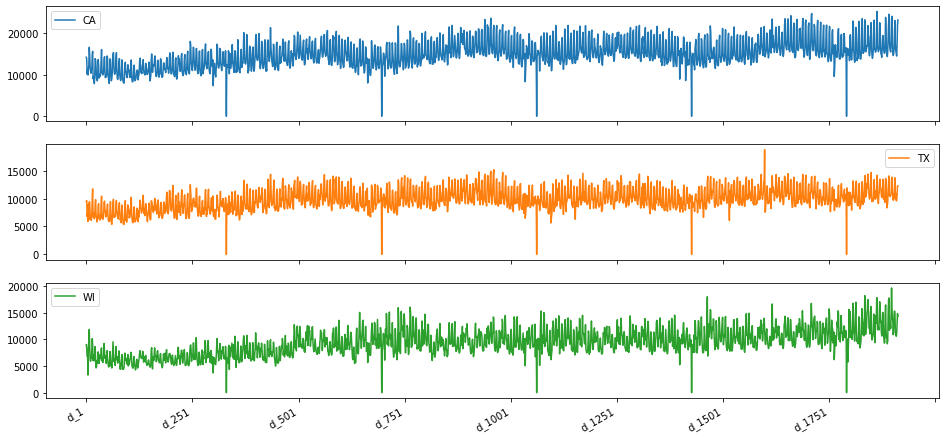

In [11]:
sales_df.groupby('state_id').sum().T.plot(subplots=True, figsize=(16, 8));

Графики временных рядов по магазинам

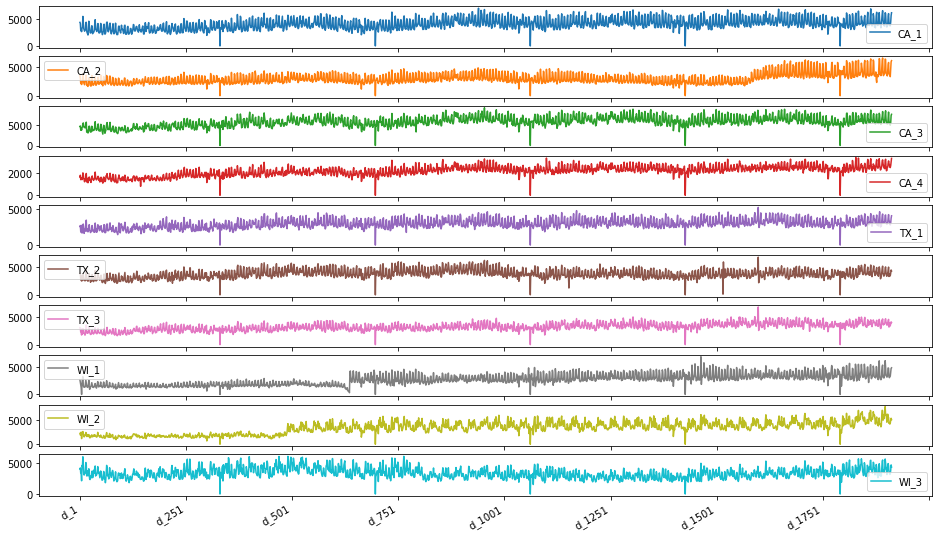

In [12]:
sales_df.groupby('store_id').sum().T.plot(subplots=True, figsize=(16, 10));

Графики временных рядов по категориям товаров за первые 50 дней

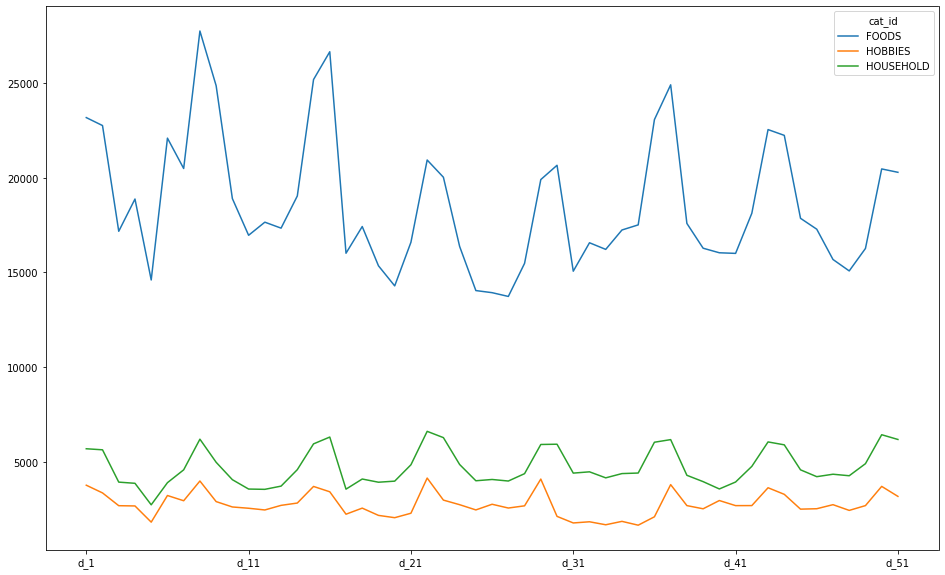

In [13]:
sales_df.groupby('cat_id').sum().loc[:,'d_1':'d_51'].T.plot(subplots=False, figsize=(16, 10));

In [14]:
sales_df['sum_for_peariod'] = sales_df.iloc[:, 6:].sum(axis=1)

In [15]:
sales_df.groupby('store_id')['sum_for_peariod'].describe()

,count,mean,std,min,25%,50%,75%,max
store_id,,,,,,,,
CA_1,3049.0,2524.833060,5352.040144,21.0,491.0,1122.0,2446.0,127203.0
CA_2,3049.0,1864.701541,3291.102932,12.0,356.0,858.0,2054.0,63416.0
CA_3,3049.0,3669.458839,8480.230419,10.0,597.0,1475.0,3472.0,250502.0
CA_4,3049.0,1345.908823,2414.427306,19.0,258.0,644.0,1416.0,52264.0
TX_1,3049.0,1835.123647,4487.184993,28.0,296.0,679.0,1639.0,112454.0
TX_2,3049.0,2366.147589,6422.931123,24.0,415.0,909.0,2088.0,192835.0
TX_3,3049.0,1997.156445,5442.187507,16.0,323.0,723.0,1786.0,150122.0
WI_1,3049.0,1688.770745,3020.159243,28.0,369.0,847.0,1850.0,78993.0
WI_2,3049.0,2146.281404,4613.726096,16.0,293.0,750.0,1969.0,69966.0


In [16]:
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].min()]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
6682,HOUSEHOLD_1_020_CA_3_validation,HOUSEHOLD_1_020,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,10


In [17]:
sales_df[sales_df['sum_for_peariod'] == sales_df['sum_for_peariod'].max()]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,...,160,204,86,100,88,77,141,139,130,250502


In [18]:
sales_df.groupby('cat_id').sum_for_peariod.sum()

cat_id
FOODS        45089939
HOBBIES       6124800
HOUSEHOLD    14480670
Name: sum_for_peariod, dtype: int64

In [19]:
sales_df.groupby(['cat_id', 'store_id']).sum_for_peariod.agg([min, max, np.mean, np.std])

min     max         mean           std
cat_id    store_id                                        
FOODS     CA_1       56  127203  3744.487126   7239.181323
          CA_2       12   63416  2421.892136   4285.623171
          CA_3       40  250502  5230.194850  11354.084076
          CA_4       29   52264  1962.021573   3080.538314
          TX_1       32  112454  2629.233820   6057.632145
          TX_2       24  192835  3489.995825   8948.177414
          TX_3       16  150122  2897.068894   7509.045271
          WI_1       63   78993  2392.729297   3937.560969
          WI_2       16   69966  3318.151705   6035.809164
          WI_3       38  121434  3292.052888   7568.323449
HOBBIES   CA_1       21   22744  1551.642478   2900.223948
          CA_2       31   13957  1128.854867   1900.524455
          CA_3       32   29742  1700.791150   3145.570095
          CA_4       24   14469   999.035398   2076.635238
          TX_1       28    7648   759.440708   1144.049272
          TX_2       49   10027  1125.658407   1517.271619
          TX_3       31   11291   933.200000   1349.818398
          WI_1       28   13761  1160.523894   2027.421676
          WI_2       25    8696   655.246018   1024.677630
          WI_3       13    7816   825.961062   1288.508771
HOUSEHOLD CA_1       21   14604  1376.036294   1763.994558
          CA_2       48   15952  1497.051576   1883.013739
          CA_3       10   43351  2589.725883   4542.264043
          CA_4       19    6371   687.484241    783.066337
          TX_1       28   19879  1325.691500   2416.327765
          TX_2       44   19043  1493.087870   2391.252328
          TX_3       37   23321  1336.183381   2398.122972
          WI_1       35   10881  1007.654250   1334.862792
          WI_2       23   29483  1342.515759   2777.291903
          WI_3       25   16912  1175.199618   2105.721219

Используем календарь для анализа данных с учетом различных событий

In [20]:
sales_df.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
24490,HOBBIES_1_103_WI_2_validation,HOBBIES_1_103,HOBBIES_1,HOBBIES,WI_2,WI,0,3,0,0,...,7,1,0,0,6,2,2,0,0,3583
2109,FOODS_2_283_CA_1_validation,FOODS_2_283,FOODS_2,FOODS,CA_1,CA,8,6,8,7,...,0,0,5,3,0,2,0,5,2,6607
3198,HOBBIES_1_154_CA_2_validation,HOBBIES_1_154,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,2,0,1,1,1,0,1,1,1,900
13038,HOUSEHOLD_1_284_TX_1_validation,HOUSEHOLD_1_284,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,0,0,0,0,...,3,0,0,0,0,0,2,4,0,1021
18101,FOODS_3_632_TX_2_validation,FOODS_3_632,FOODS_3,FOODS,TX_2,TX,0,0,0,0,...,3,0,2,2,2,1,2,1,1,1806


In [21]:
sales_df.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
20339,FOODS_2_219_TX_3_validation,FOODS_2_219,FOODS_2,FOODS,TX_3,TX,0,0,0,0,...,0,0,0,0,0,0,0,3,0,768
30239,FOODS_3_574_WI_3_validation,FOODS_3_574,FOODS_3,FOODS,WI_3,WI,4,10,5,1,...,0,4,0,1,5,4,7,1,0,7296
6203,HOBBIES_1_110_CA_3_validation,HOBBIES_1_110,HOBBIES_1,HOBBIES,CA_3,CA,1,0,3,0,...,1,1,1,0,1,1,0,0,0,497
5885,FOODS_3_612_CA_2_validation,FOODS_3_612,FOODS_3,FOODS,CA_2,CA,0,0,0,0,...,0,1,1,0,0,0,1,2,0,977
10325,HOUSEHOLD_2_082_CA_4_validation,HOUSEHOLD_2_082,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,2,0,2,0,0,0,0,0,410


In [22]:
events_days = pd.concat([sales_df.loc[:, :'state_id'],
                         sales_df[calendar_df[:1913][~calendar_df.event_type_1[:1913].isna()].d]],
                       axis = 1)
events_days.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_9,d_17,d_24,d_40,...,d_1805,d_1816,d_1836,d_1839,d_1843,d_1844,d_1846,d_1875,d_1882,d_1885
27326,FOODS_3_711_WI_2_validation,FOODS_3_711,FOODS_3,FOODS,WI_2,WI,39,51,0,0,...,0,0,0,0,0,77,59,0,0,26
4631,HOUSEHOLD_2_487_CA_2_validation,HOUSEHOLD_2_487,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8431,FOODS_3_109_CA_3_validation,FOODS_3_109,FOODS_3,FOODS,CA_3,CA,15,6,5,21,...,3,4,0,5,2,3,4,1,1,6
8701,FOODS_3_379_CA_3_validation,FOODS_3_379,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,0,0,0,1,0,2,0,0,0,2
5668,FOODS_3_395_CA_2_validation,FOODS_3_395,FOODS_3,FOODS,CA_2,CA,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0


In [23]:
not_events_days = pd.concat([sales_df.loc[:, :'state_id'],
                         sales_df[calendar_df[:1913][(calendar_df.event_type_1[:1913].isna())&(calendar_df.event_type_2[:1913].isna())].d]],
                       axis = 1)
not_events_days.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
17991,FOODS_3_522_TX_2_validation,FOODS_3_522,FOODS_3,FOODS,TX_2,TX,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
29952,FOODS_3_287_WI_3_validation,FOODS_3_287,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,1,2,0,0,0,0,1
27524,HOBBIES_1_086_WI_3_validation,HOBBIES_1_086,HOBBIES_1,HOBBIES,WI_3,WI,0,0,0,1,...,1,0,0,0,1,0,0,2,1,0
24968,HOUSEHOLD_1_012_WI_2_validation,HOUSEHOLD_1_012,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,0,0,0,0,...,1,2,0,0,0,2,2,1,2,0
17938,FOODS_3_469_TX_2_validation,FOODS_3_469,FOODS_3,FOODS,TX_2,TX,3,5,2,3,...,2,0,0,0,1,3,1,2,1,4


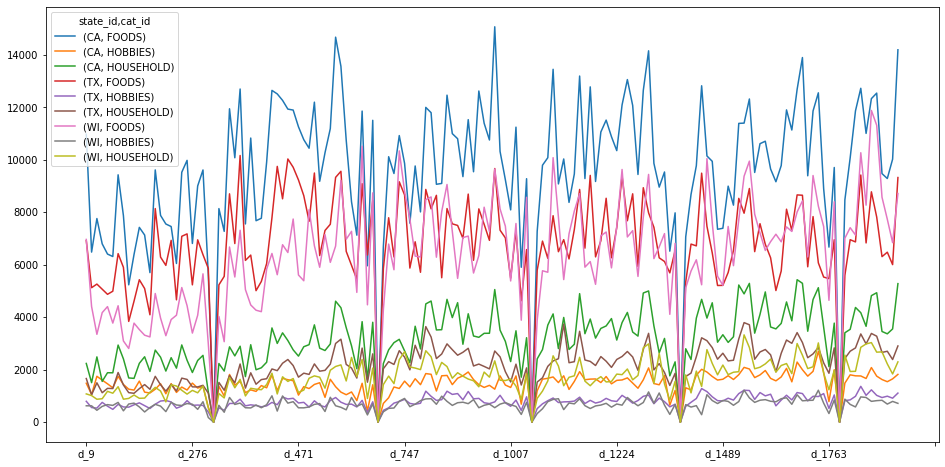

In [24]:
events_days.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8));

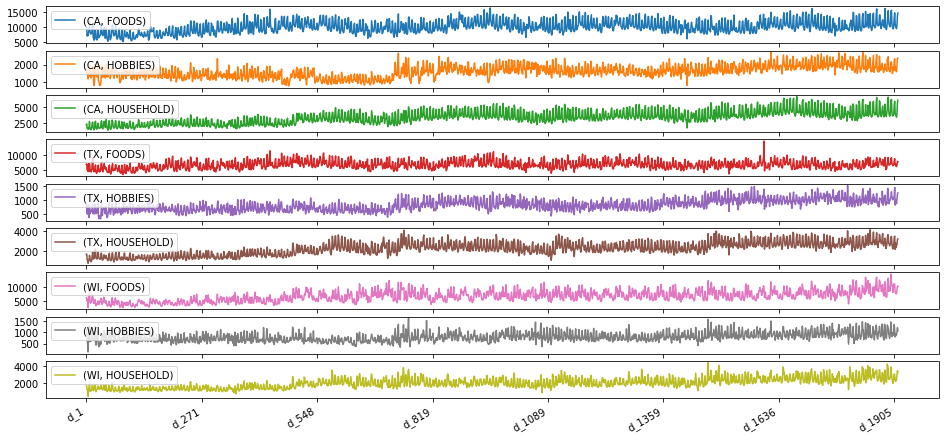

In [25]:
not_events_days.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=True, figsize=(16, 8));

In [26]:
events_days.groupby(['store_id', 'cat_id']).sum()

d_9    d_17    d_24    d_40    d_47    d_48  d_51  d_86  \
store_id cat_id                                                                
CA_1     FOODS      3418  2003.0  2105.0  2100.0  1805.0  1657.0  2795  2051   
         HOBBIES     432   379.0   626.0   357.0   374.0   391.0   492   366   
         HOUSEHOLD   490   375.0   533.0   315.0   343.0   387.0   617   529   
CA_2     FOODS      1827  1132.0  1476.0  1161.0  1155.0  1295.0  1889  1705   
         HOBBIES     452   271.0   405.0   448.0   441.0   412.0   556   343   
         HOUSEHOLD   678   398.0   720.0   455.0   486.0   527.0   986   786   
CA_3     FOODS      4324  2459.0  3106.0  2630.0  2555.0  2509.0  3614  3126   
         HOBBIES     375   252.0   531.0   502.0   412.0   371.0   463   474   
         HOUSEHOLD   882   592.0   994.0   622.0   800.0   773.0  1104   882   
CA_4     FOODS      1408   889.0  1075.0   906.0   893.0   853.0  1131   991   
         HOBBIES     223   154.0   186.0   294.0   234.0   135.0   234   254   
         HOUSEHOLD   187   140.0   240.0   161.0   254.0   194.0   231   214   
TX_1     FOODS      2061  1418.0  1461.0  1609.0  1475.0  1596.0  1824  1780   
         HOBBIES     242   190.0   133.0   257.0   164.0    95.0   215   184   
         HOUSEHOLD   584   313.0   477.0   314.0   348.0   426.0   630   487   
TX_2     FOODS      2750  2014.0  2171.0  1982.0  1866.0  1893.0  2552  2457   
         HOBBIES     302   248.0   255.0   275.0   312.0   248.0   268   266   
         HOUSEHOLD   605   417.0   580.0   448.0   541.0   501.0   713   584   
TX_3     FOODS      2109  1693.0  1631.0  1476.0  1532.0  1502.0  2047  1665   
         HOBBIES     250   117.0   147.0   221.0   132.0   144.0   194   128   
         HOUSEHOLD   473   309.0   442.0   359.0   398.0   354.0   549   346   
WI_1     FOODS      1086   892.0   552.0   617.0   846.0   773.0   810   613   
         HOBBIES     325   350.0   184.0   265.0   323.0   354.0   326   153   
         HOUSEHOLD   263   280.0   203.0   275.0   361.0   314.0   380   205   
WI_2     FOODS      1786  1224.0   956.0  1134.0  1183.0  1014.0  1138   708   
         HOBBIES      78    97.0   108.0   114.0   106.0   119.0    97    76   
         HOUSEHOLD   276   291.0   292.0   232.0   361.0   321.0   321   165   
WI_3     FOODS      4093  2291.0  1840.0  2424.0  2375.0  1989.0  2489  1774   
         HOBBIES     220   175.0   160.0   222.0   238.0   165.0   329   202   
         HOUSEHOLD   537   441.0   377.0   385.0   452.0   467.0   649   504   

                      d_88    d_97  ...  d_1805  d_1816  d_1836  d_1839  \
store_id cat_id                     ...                                   
CA_1     FOODS      1411.0  1648.0  ...    2395    2905    3464  2674.0   
         HOBBIES     332.0   397.0  ...     541     609     481   538.0   
         HOUSEHOLD   342.0   339.0  ...     931     970    1041   783.0   
CA_2     FOODS      1049.0  1268.0  ...    2187    2949    3012  2420.0   
         HOBBIES     363.0   269.0  ...     421     421     270   309.0   
         HOUSEHOLD   433.0   473.0  ...     875    1230     969   857.0   
CA_3     FOODS      2043.0  2538.0  ...    3925    4151    4419  4397.0   
         HOBBIES     403.0   404.0  ...     449     427     578   452.0   
         HOUSEHOLD   699.0   669.0  ...    1270    1664    1699  1572.0   
CA_4     FOODS       732.0   938.0  ...    1570    1862    1833  1517.0   
         HOBBIES     158.0   151.0  ...     392     308     431   365.0   
         HOUSEHOLD   211.0   187.0  ...     462     508     463   441.0   
TX_1     FOODS      1294.0  1582.0  ...    1705    2015    2602  1701.0   
         HOBBIES     136.0   173.0  ...     190     234     459   213.0   
         HOUSEHOLD   347.0   303.0  ...     793     907     973   831.0   
TX_2     FOODS      1439.0  1712.0  ...    2555    2391    3500  2691.0   
         HOBBIES     207.0   291.0  ...     316     372     453   425.0   
         HOUSEHOLD   431.0   449.0 

In [27]:
not_events_days.groupby(['store_id', 'cat_id']).sum() #.T.plot(subplots=True, figsize=(16, 20))

d_1   d_2   d_3   d_4   d_5   d_6   d_7   d_8  d_10  \
store_id cat_id                                                            
CA_1     FOODS      3239  3137  2008  2258  2032  2407  2693  3962  2446   
         HOBBIES     556   498   415   392   268   467   346   769   384   
         HOUSEHOLD   542   520   393   401   330   402   411   706   327   
CA_2     FOODS      2193  1921  1289  1540  1278  1494  1785  2385  1355   
         HOBBIES     538   397   368   350   296   391   316   413   403   
         HOUSEHOLD   763   728   464   434   368   403   528   931   460   
CA_3     FOODS      3446  3535  2701  3064  2761  3340  3455  4068  3718   
         HOBBIES     550   430   438   424   364   390   493   525   478   
         HOUSEHOLD   743   862   646   744   692   639   755   863   716   
CA_4     FOODS      1223  1269   946  1002  1107  1015  1072  1455  1118   
         HOBBIES     158   236   251   239   253   211   159   279   243   
         HOUSEHOLD   244   272   189   199   176   163   238   254   174   
TX_1     FOODS      1781  1903  1377  1643  1329  2091  1247  2008  1579   
         HOBBIES     251   264   107   248   102   292    89   264   127   
         HOUSEHOLD   524   520   338   367   263   351   355   548   468   
TX_2     FOODS      2788  2870  2082  2180  1890  2696  1963  2890  2189   
         HOBBIES     385   359   229   359   257   318   162   270   273   
         HOUSEHOLD   679   708   420   415   345   425   463   612   470   
TX_3     FOODS      2284  2257  1665  1647  1383  2280  1461  2157  1737   
         HOBBIES     243   247   190   202   142   221   139   251   124   
         HOUSEHOLD   503   502   370   320   201   332   347   440   352   
WI_1     FOODS      1581  1327   977   935     2  1278  1671  2016   835   
         HOBBIES     615   443   323   137     0   468   734   640   249   
         HOUSEHOLD   508   424   262   179     0   303   410   592   271   
WI_2     FOODS      1615  1433  1586  2013   967  1709  1668  2064  1389   
         HOBBIES     190   127   113   124    58   169   146   163    91   
         HOUSEHOLD   451   362   319   385   150   366   418   416   356   
WI_3     FOODS      3028  3106  2543  2596  1854  3783  3475  4746  2535   
         HOBBIES     278   356   248   194    74   293   360   412   243   
         HOUSEHOLD   732   736   526   421   204   514   651   833   462   

                    d_11  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
store_id cat_id           ...                                                   
CA_1     FOODS      2138  ...    2706    3481    4004  2886.0  2488.0  2490.0   
         HOBBIES     496  ...     401     722     655   542.0   495.0   363.0   
         HOUSEHOLD   361  ...     875    1234    1295   917.0   810.0   869.0   
CA_2     FOODS      1383  ...    2891    3423    3729  2625.0  2410.0  2506.0   
         HOBBIES     284  ...     483     486     483   320.0   368.0   344.0   
         HOUSEHOLD   456  ...    1066    1443    1548   885.0   853.0   841.0   
CA_3     FOODS      3473  ...    3471    4307    5127  3827.0  3468.0  3286.0   
         HOBBIES     401  ...     432     635     848   467.0   588.0   534.0   
         HOUSEHOLD   573  ...    1434    1994    2296  1774.0  1627.0  1415.0   
CA_4     FOODS       967  ...    1664    1883    1995  1879.0  1722.0  1581.0   
         HOBBIES     200  ...     342     333     344   377.0   398.0   405.0   
         HOUSEHOLD   201  ...     490     623     708   553.0   557.0   514.0   
TX_1     FOODS      1173  ...    2049    2412    2629  2434.0  2113.0  1834.0   
         HOBBIES     118  ...     258     273     447   216.0   292.0   273.0   
         HOUSEHOLD   316  ...     777    1039    1116   760.0   852.0   794.0   
TX_2     FOODS      1986  ...    2549    2795    3221  2268.0  2440.0  2196.0   
         HOBBIES     253  ...     360     407     468   328.0   299.0   373.0   
         HOUSEHOLD   389  ...     988    1273    

In [28]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [29]:
snapCA = pd.concat([not_events_days.loc[not_events_days.state_id=='CA', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='CA', calendar_df[:1913][(calendar_df[:1913].snap_CA==1) & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
snapTX = pd.concat([not_events_days.loc[not_events_days.state_id=='TX', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='TX', calendar_df[:1913][(calendar_df[:1913].snap_TX==1)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
snapWI = pd.concat([not_events_days.loc[not_events_days.state_id=='WI', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='WI', calendar_df[:1913][(calendar_df[:1913].snap_WI==1)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapCA = pd.concat([not_events_days.loc[not_events_days.state_id=='CA', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='CA', calendar_df[:1913][(calendar_df[:1913].snap_CA==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapTX = pd.concat([not_events_days.loc[not_events_days.state_id=='TX', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='TX', calendar_df[:1913][(calendar_df[:1913].snap_TX==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)
not_snapWI = pd.concat([not_events_days.loc[not_events_days.state_id=='WI', :'state_id'],
                         not_events_days.loc[not_events_days.state_id=='WI', calendar_df[:1913][(calendar_df[:1913].snap_WI==0)  & (calendar_df.event_type_1[:1913].isna())].d]],
                       axis = 1)

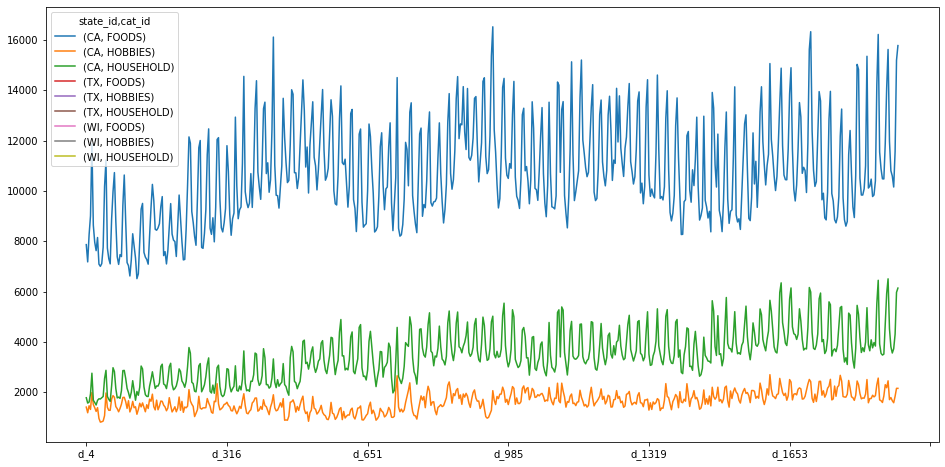

In [30]:
snapCA.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8));

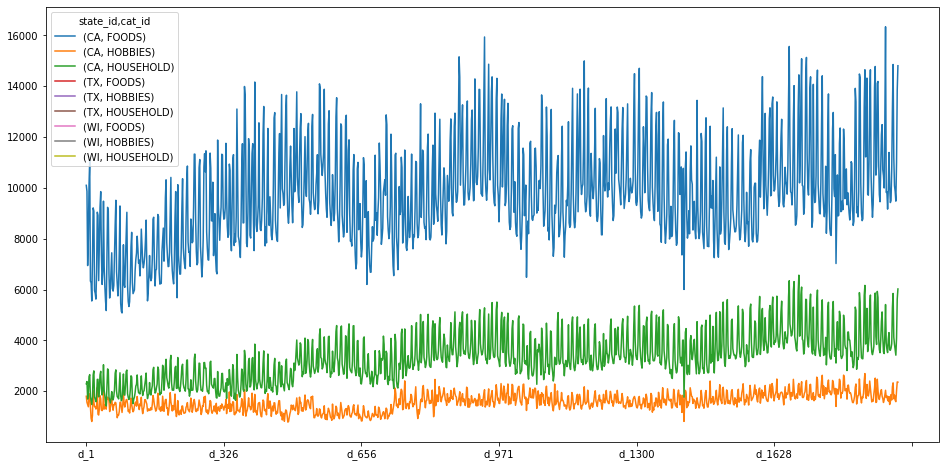

In [31]:
not_snapCA.groupby(['state_id', 'cat_id']).sum().T.plot(subplots=False, figsize=(16, 8));

Анализ таблицы цен

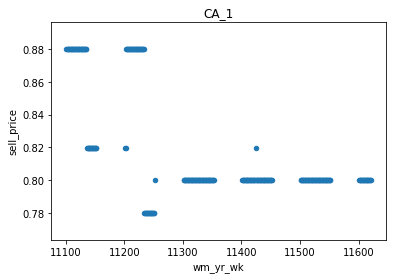

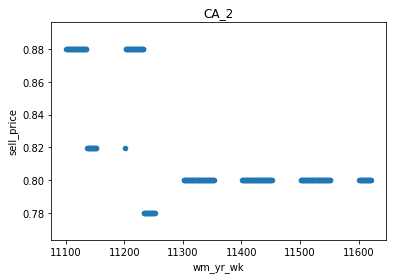

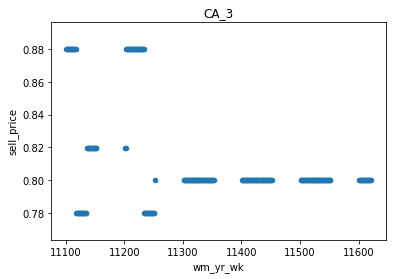

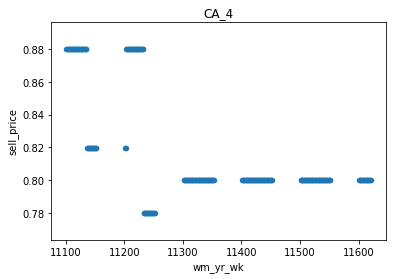

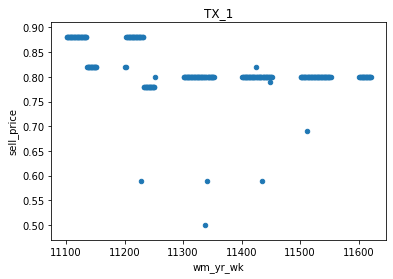

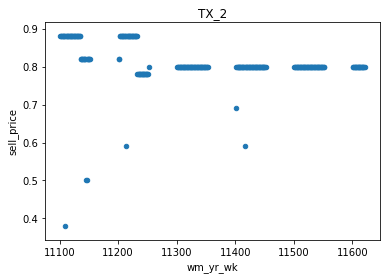

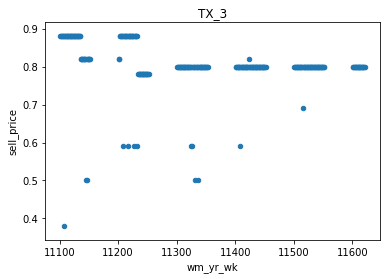

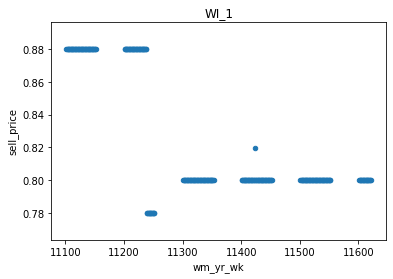

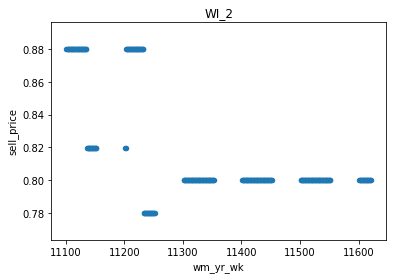

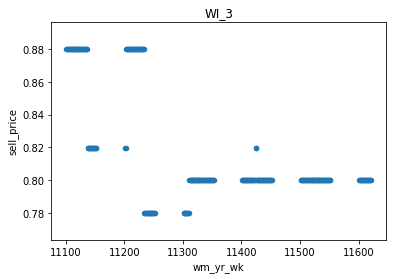

In [32]:
one_item = prices_df[prices_df.item_id == 'FOODS_3_133']
for id in one_item.store_id.unique():
    df =  one_item[one_item.store_id==id]
    df.plot.scatter('wm_yr_wk','sell_price', title=id)

In [33]:
prices_df[(prices_df.item_id == 'HOBBIES_1_001') & (prices_df.store_id == 'TX_1')].wm_yr_wk.values

array([11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333,
       11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342,
       11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351,
       11352, 11353, 11401, 11402, 11403, 11404, 11405, 11406, 11407,
       11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416,
       11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425,
       11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434,
       11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443,
       11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452,
       11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509,
       11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518,
       11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527,
       11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536,
       11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545,
       11546, 11547,

In [34]:
sales_df[(sales_df.item_id == 'HOBBIES_1_001') & (sales_df.store_id=='CA_1')].groupby('store_id').sum() #calendar_df.wm_yr_wk == 11353

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_for_peariod
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,0,0,0,0,0,0,0,0,0,0,...,3,0,1,1,1,3,0,1,1,600
CA_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TX_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TX_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TX_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WI_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WI_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline model

In [35]:
# импортируем библиотеки для работы со временем, очистки от лишних ссылок в памяти, биб
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb

# задаем переменные
pd.options.display.max_columns = 50
# соответствие имен столбцов их типам данных
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

FIRST_DAY = 800 # Если хотите загрузить все данные, то установите '1' -->  Но при этом высокий риск, что не хватит памяти !
h = 28 # количество дней, на которые создается предсказание
max_lags = 366 # основываясь на каком количестве дней мы будем строить предсказание 
tr_last = 1913 # последний день для тренировки
fday = datetime(2016,4, 25) # дата первого дня для предсказания
fday

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


datetime.datetime(2016, 4, 25, 0, 0)

In [36]:
# собираем все таблицы в одну
def create_dt(is_train = True, nrows = None, first_day = 1200):
    # таблица цен. Кодируем категориальные признанки в числа типа int
    prices = pd.read_csv("../data/input/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
    # таблица календарь. Кодируем категориальные признанки в числа типа int
    cal = pd.read_csv("../data/input/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    # вычисляем день, начиная с которого будем использовать данные
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)] # выбираем числовые данные
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'] # выбираем категориальные данные
    dtype = {numcol:"float32" for numcol in numcols} # задаем тип данных для числовых столбцов
    dtype.update({col: "category" for col in catcols if col != "id"})
    # скачиваем данные о покупках
    dt = pd.read_csv("../data/input/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    # кодируем категориальные признаки
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    # если имеем дело с тренировочным набором данных, то задаем пустые дни для предсказания
    if not is_train:
        for day in range(tr_last+1, tr_last+ 2*h +1):
            dt[f"d_{day}"] = np.nan
    # 
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [37]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [38]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 20 s, sys: 7.44 s, total: 27.4 s
Wall time: 28.4 s


(31522396, 22)

In [39]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_800,0.0,2013-04-07,11311,3,2,4,2013,0,0,0,0,1.0,1.0,0.0,3.97
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_801,0.0,2013-04-08,11311,1,3,4,2013,0,0,0,0,1.0,0.0,1.0,3.97
2,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_802,0.0,2013-04-09,11311,5,4,4,2013,0,0,0,0,1.0,1.0,1.0,3.97
3,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_803,0.0,2013-04-10,11311,6,5,4,2013,0,0,0,0,1.0,0.0,0.0,3.97
4,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_804,0.0,2013-04-11,11311,4,6,4,2013,0,0,0,0,0.0,1.0,1.0,3.97


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31522396 entries, 0 to 31522395
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory us

In [41]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2404.97 MB
Memory usage after optimization is: 1715.07 MB
Decreased by 28.7%


In [42]:
%%time

create_fea(df)
df.shape

CPU times: user 1min 31s, sys: 13.8 s, total: 1min 44s
Wall time: 1min 46s


(31522396, 31)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31522396 entries, 0 to 31522395
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       int16         
 2   dept_id       int8          
 3   store_id      int8          
 4   cat_id        int8          
 5   state_id      int8          
 6   d             category      
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int8          
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [51]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1309434,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_855,0.0,2013-06-01,11319,2,1,6,2013,0,0,0,0,1.0,1.0,0.0,3.97,0.0,1.0,0.142857,0.142857,0.285714,0.142857,22,2,1
1309435,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_856,0.0,2013-06-02,11319,3,2,6,2013,0,0,0,0,1.0,0.0,1.0,3.97,0.0,1.0,0.142857,0.285714,0.285714,0.178571,22,2,2
1309436,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_857,1.0,2013-06-03,11319,1,3,6,2013,0,0,0,0,1.0,1.0,1.0,3.97,0.0,0.0,0.142857,0.285714,0.285714,0.178571,23,2,3
1309437,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_858,1.0,2013-06-04,11319,5,4,6,2013,0,0,0,0,1.0,0.0,0.0,3.97,0.0,0.0,0.142857,0.285714,0.285714,0.178571,23,2,4
1309438,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_859,0.0,2013-06-05,11319,6,5,6,2013,0,0,0,0,1.0,1.0,1.0,3.97,0.0,0.0,0.142857,0.285714,0.285714,0.178571,23,2,5


In [52]:
df.dropna(inplace = True)
df.shape

(29845446, 31)

In [53]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2392.41 MB
Memory usage after optimization is: 2392.41 MB
Decreased by 0.0%


In [54]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [55]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
fake_valid_inds = np.random.choice(len(X_train), 1000000)
fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [56]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1500,
#     'device' : 'gpu'
}

In [57]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	valid_0's rmse: 2.79746
[100]	valid_0's rmse: 2.43543
[150]	valid_0's rmse: 2.38617
[200]	valid_0's rmse: 2.36218
[250]	valid_0's rmse: 2.34496
[300]	valid_0's rmse: 2.31882
[350]	valid_0's rmse: 2.30332
[400]	valid_0's rmse: 2.2886
[450]	valid_0's rmse: 2.27671
[500]	valid_0's rmse: 2.26075
[550]	valid_0's rmse: 2.24515
[600]	valid_0's rmse: 2.23555
[650]	valid_0's rmse: 2.22863
[700]	valid_0's rmse: 2.22052
[750]	valid_0's rmse: 2.20927
[800]	valid_0's rmse: 2.201
[850]	valid_0's rmse: 2.19696
[900]	valid_0's rmse: 2.19065
[950]	valid_0's rmse: 2.18726
[1000]	valid_0's rmse: 2.18137
[1050]	valid_0's rmse: 2.17472
[1100]	valid_0's rmse: 2.1703
[1150]	valid_0's rmse: 2.16603
[1200]	valid_0's rmse: 2.16215
[1250]	valid_0's rmse: 2.15908
[1300]	valid_0's rmse: 2.15589
[1350]	valid_0's rmse: 2.15206
[1400]	valid_0's rmse: 2.14894
[1450]	valid_0's rmse: 2.14478
[1500]	valid_0's rmse: 2.14165
CPU times: user 4h 22min 35s, sys: 42.5 s, total: 4h 23min 17s
Wall time: 33min 37s


In [58]:
%%time

te = create_dt(False)
te.shape

CPU times: user 9.69 s, sys: 2.38 s, total: 12.1 s
Wall time: 12.3 s


(12864391, 22)

In [59]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2392.41 MB
Memory usage after optimization is: 2392.41 MB
Decreased by 0.0%


In [ ]:
%%time

for i in range(0, 28):
    day = fday + timedelta(days=i)
    print(i, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    create_fea(tst)
    tst = tst.loc[tst.date == day , train_cols]
    te.loc[te.date == day, "sales"] = 1.02*m_lgb.predict(tst) # magic multiplier by kyakovlev

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00


In [ ]:
%%time

te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                      "id"].str.replace("validation$", "evaluation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.to_csv("submission.csv",index=False)
te_sub.shape

In [ ]:
te_sub.head(10)